In [1]:
import pandas as pd
import numpy as np
import sklearn
import anndata
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from ALLCools.plot import *

from sklearn.neighbors import KNeighborsClassifier
import pathlib
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.metrics import (balanced_accuracy_score, confusion_matrix,
                             fbeta_score, make_scorer)
from sklearn.model_selection import StratifiedKFold

## Parameters

In [2]:
n_estimators = 200
random_seed = 0
n_splits = 10
n_jobs = 40
cluster_col = 'SubType'

In [3]:
integration_adata_path = 'Integration/Integration.h5ad'
mc_tidy_data_path = 'Integration/mc_cell_tidy_data.with_integration_info.msg'
rna_tidy_data_path = 'Integration/rna_cell_tidy_data.with_integration_info.msg'

output_dir = 'Model'
output_dir = pathlib.Path(output_dir)
output_dir.mkdir(exist_ok=True)

## Load Data

In [4]:
mc_tidy_data = pd.read_msgpack(mc_tidy_data_path)
rna_tidy_data = pd.read_msgpack(rna_tidy_data_path)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
adata = anndata.read_h5ad(integration_adata_path)
adata

AnnData object with n_obs × n_vars = 20126 × 682 
    obs: 'Modality', 'leiden'
    uns: 'Modality_colors', 'leiden', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [6]:
mc_pcs = pd.DataFrame(
    adata.obsm['X_pca'],
    index=adata.obs_names).loc[adata.obs['Modality'] == 'mC', :].copy()
rna_pcs = pd.DataFrame(
    adata.obsm['X_pca'],
    index=adata.obs_names).loc[adata.obs['Modality'] == 'RNA', :].copy()

In [7]:
mc_label = mc_tidy_data[cluster_col].reindex(mc_pcs.index).astype(str)
rna_label = rna_tidy_data[cluster_col].reindex(rna_pcs.index).astype(str)

## RNA to mC

### mC Train

In [8]:
estimator = BalancedRandomForestClassifier(n_estimators=n_estimators,
                                           criterion='gini',
                                           max_depth=None,
                                           min_samples_split=2,
                                           min_samples_leaf=2,
                                           min_weight_fraction_leaf=0.0,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           bootstrap=True,
                                           oob_score=False,
                                           sampling_strategy='auto',
                                           replacement=False,
                                           n_jobs=n_jobs // n_splits + 1,
                                           random_state=random_seed,
                                           verbose=3,
                                           warm_start=False,
                                           class_weight=None)

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

# TODO change to balanced accuracy score
scoring = make_scorer(balanced_accuracy_score)

mc_clf = RFECV(estimator,
            step=3,
            min_features_to_select=1,
            cv=cv,
            scoring=scoring,
            verbose=3,
            n_jobs=n_splits)

In [9]:
mc_clf.fit(mc_pcs, mc_label)
joblib.dump(mc_clf, 'Model/mC.RFECV.lib')

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s


building tree 1 of 200
building tree 5 of 200
building tree 4 of 200
building tree 2 of 200
building tree 3 of 200
building tree 6 of 200
building tree 7 of 200
building tree 9 of 200
building tree 8 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 15 of 200
building tree 14 of 200
building tree 16 of 200
building tree 17 of 200
building tree 19 of 200
building tree 18 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 25 of 200
building tree 24 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 35 of 200
building tree 34 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    1.0s


building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200building tree 135 of 200

building tree 136 of 200
building tree 138 of 200
building tree 140 of 200
building tree 137 of 200
building tree 139 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 151 of 200
building tree 150 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 167 of 200
building tree 166 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200


[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s


building tree 4 of 200
building tree 1 of 200
building tree 5 of 200
building tree 3 of 200
building tree 2 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 10 of 200
building tree 9 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 30 of 200
building tree 29 of 200
building tree 32 of 200
building tree 31 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.9s


building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 146 of 200building tree 145 of 200

building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 151 of 200
building tree 150 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 166 of 200
building tree 167 of 200
building tree 165 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200


[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    1.5s finished


['Model/mC.RFECV.lib']

### Pred RNA

#### Cell Level

In [10]:
rna_pred = mc_clf.predict(rna_pcs)
rna_pred_proba = mc_clf.predict_proba(rna_pcs)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.1s finished


In [11]:
cell_level_pred = pd.DataFrame([rna_pred_proba.max(axis=1), rna_pred, rna_label], columns=rna_pcs.index).T
cell_level_pred.columns = ['BestProba', 'BestLabel', 'OriginalLabel']
cell_level_pred.to_csv('Model/RNA_cell_to_mC_cluster.csv')

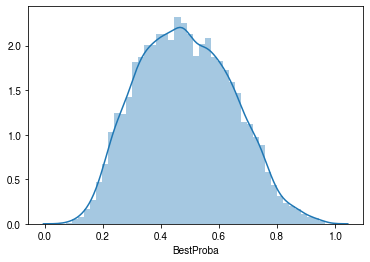

In [12]:
sns.distplot(cell_level_pred['BestProba'])

In [13]:
rna_pred_and_true = pd.DataFrame([rna_pred, rna_label], columns=rna_label.index).T
rna_pred_and_true.columns = ['Pred', 'True']

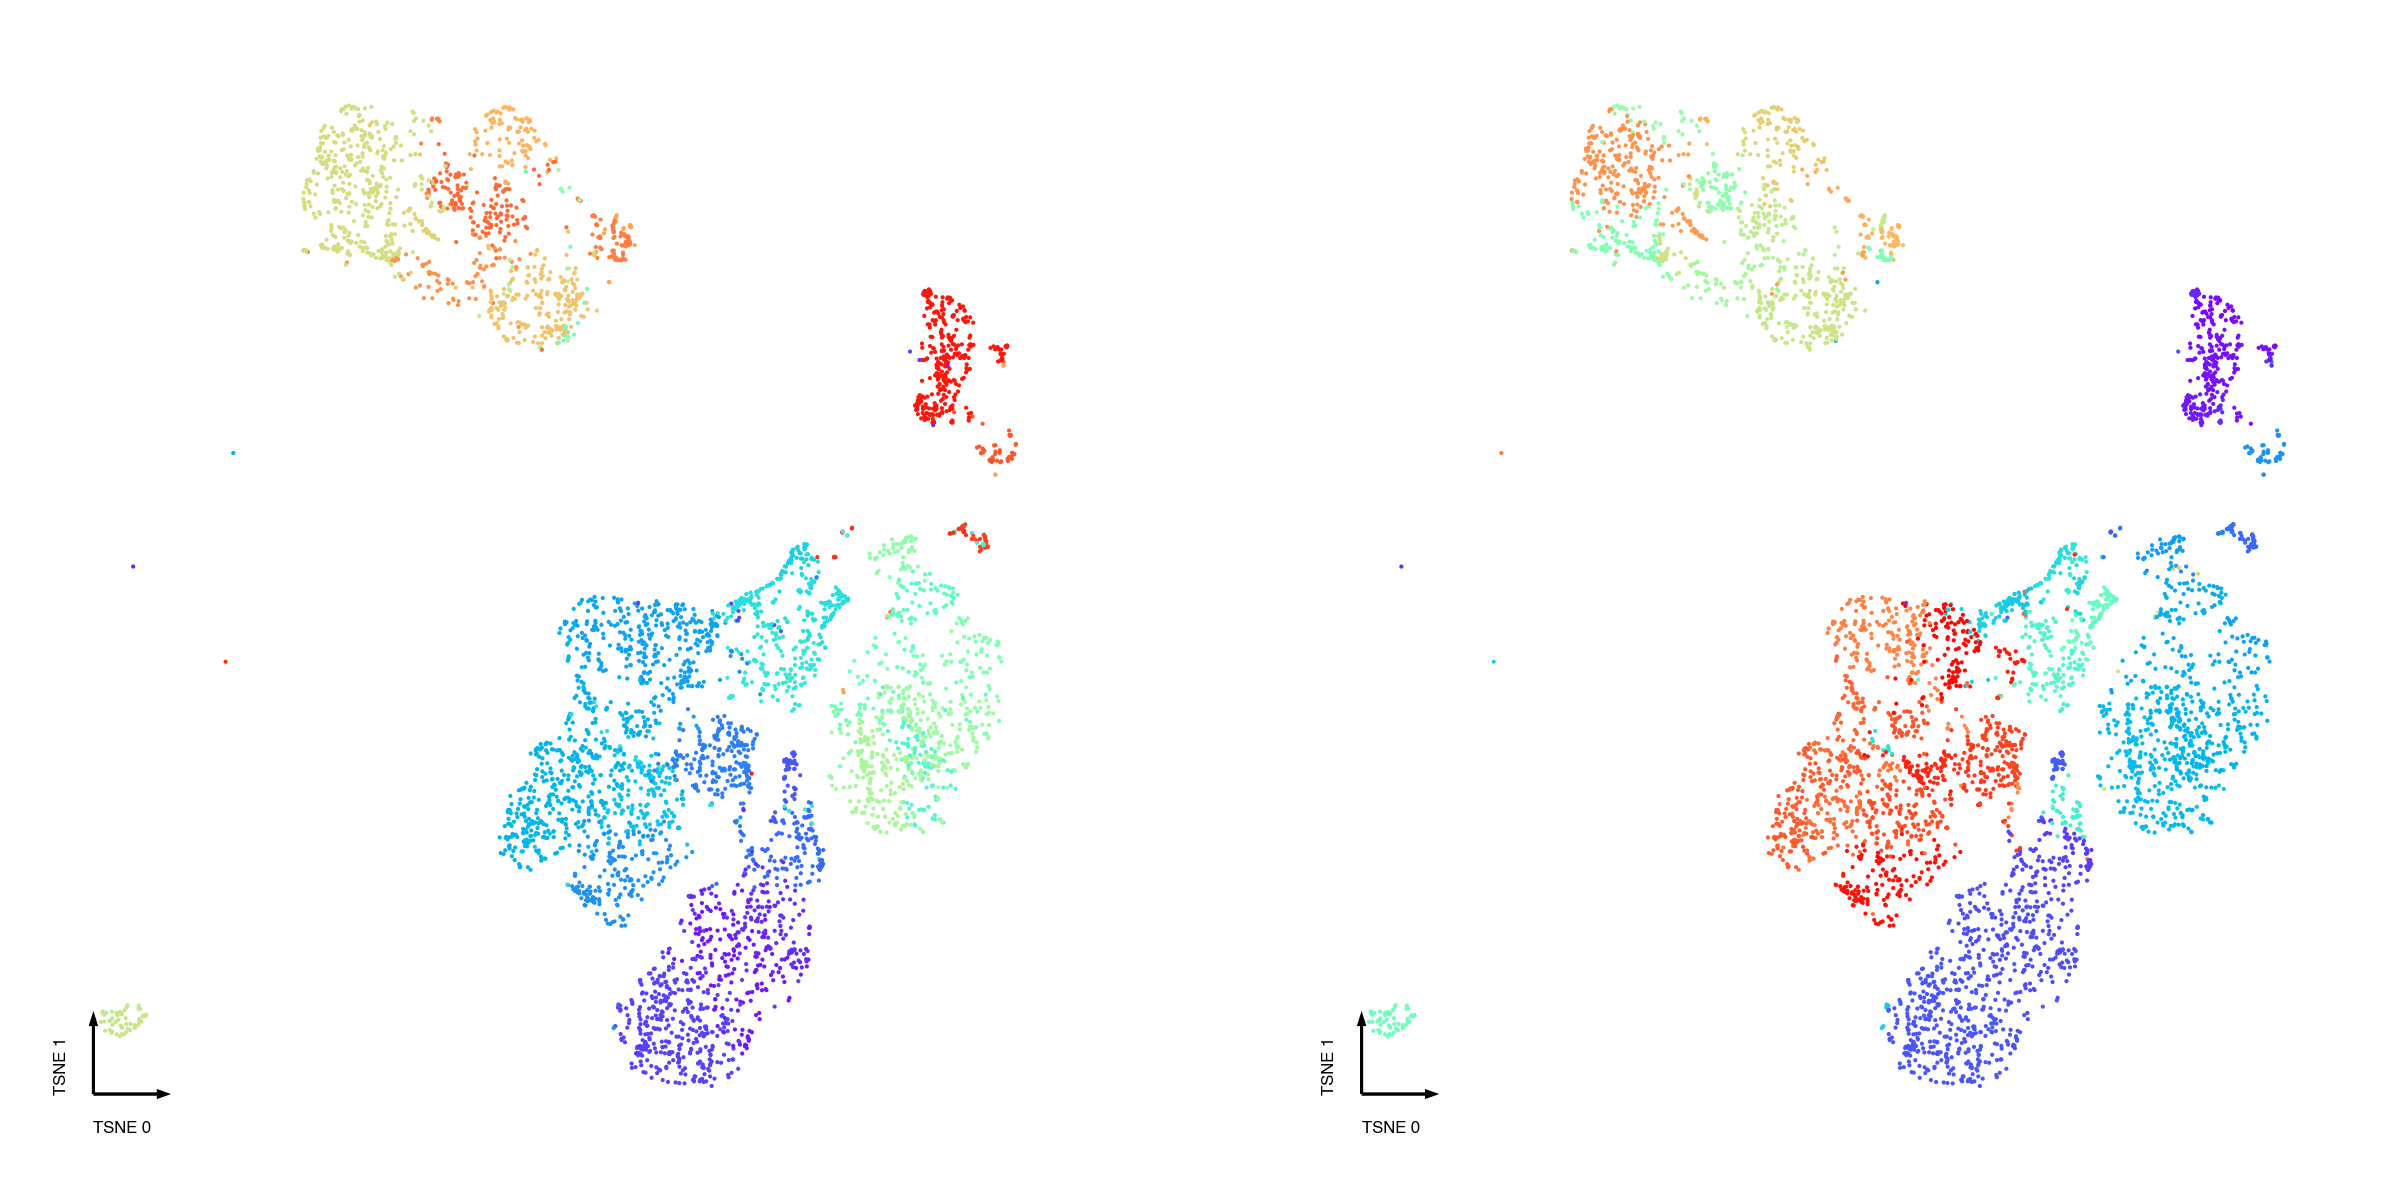

In [14]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), dpi=300, ncols=2)

categorical_scatter(data=rna_tidy_data, ax=ax1, coord_base='tsne', 
                    hue=rna_pred_and_true['Pred'], s=1)

categorical_scatter(data=rna_tidy_data, ax=ax2, coord_base='tsne', 
                    hue=rna_pred_and_true['True'], s=1)

pass

#### Cluster Level

In [15]:
pred_true_count = rna_pred_and_true.groupby('True')['Pred'].value_counts().unstack().fillna(0).astype(int)
pred_true_ratio = pred_true_count / pred_true_count.sum(axis=1).values[:, None]

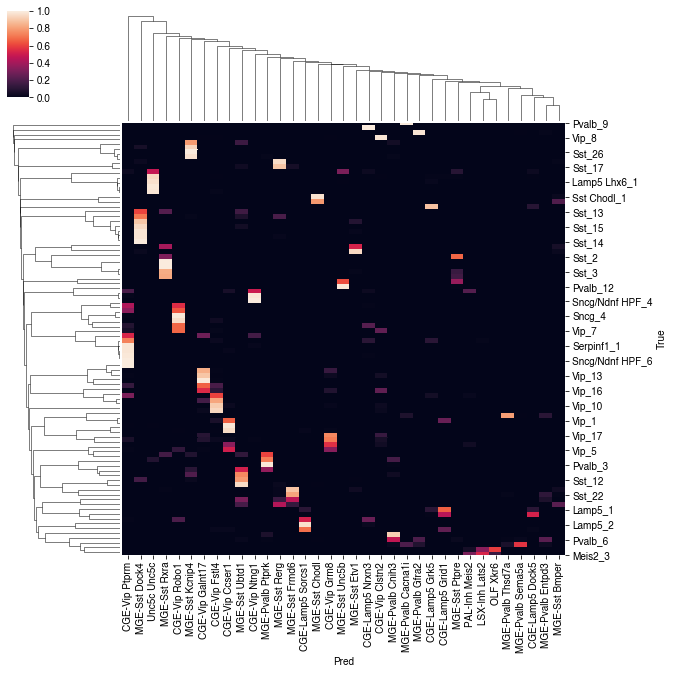

In [16]:
sns.clustermap(pred_true_ratio)

In [17]:
cluster_level_pred = pd.DataFrame(index=rna_tidy_data[cluster_col].unique())
cluster_level_pred['BestProba'] = pred_true_ratio.apply(lambda i: i.max(), axis=1)
cluster_level_pred['BestMatch'] = pred_true_ratio.apply(lambda i: i.idxmax(), axis=1)
cluster_level_pred.to_csv('Model/RNA_cluster_to_mC_cluster.csv')

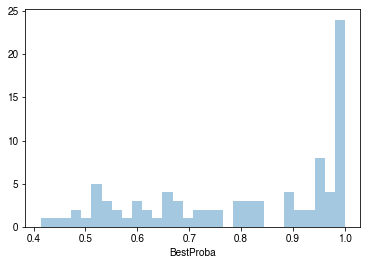

In [18]:
sns.distplot(cluster_level_pred['BestProba'], bins=30, kde=False)

In [19]:
print('RNA cluster best match to mC cluster:', cluster_level_pred['BestMatch'].value_counts().size)
print('Total mC cluster:', mc_tidy_data[cluster_col].unique().size)
print('Total RNA cluster:', rna_tidy_data[cluster_col].unique().size)

RNA cluster best match to mC cluster: 33
Total mC cluster: 35
Total RNA cluster: 90


## mC to RNA

### RNA Train

In [20]:
estimator = BalancedRandomForestClassifier(n_estimators=n_estimators,
                                           criterion='gini',
                                           max_depth=None,
                                           min_samples_split=2,
                                           min_samples_leaf=2,
                                           min_weight_fraction_leaf=0.0,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           bootstrap=True,
                                           oob_score=False,
                                           sampling_strategy='auto',
                                           replacement=False,
                                           n_jobs=n_jobs // n_splits + 1,
                                           random_state=random_seed,
                                           verbose=3,
                                           warm_start=False,
                                           class_weight=None)

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

# TODO change to balanced accuracy score
scoring = make_scorer(balanced_accuracy_score)

rna_clf = RFECV(estimator,
            step=3,
            min_features_to_select=1,
            cv=cv,
            scoring=scoring,
            verbose=3,
            n_jobs=n_splits)

In [21]:
rna_clf.fit(rna_pcs, rna_label)
joblib.dump(rna_clf, 'Model/RNA.RFECV.lib')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 3 of 200
building tree 1 of 200
building tree 4 of 200
building tree 5 of 200
building tree 2 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 13 of 200
building tree 12 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 18 of 200
building tree 17 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.4s


building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73

[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    2.0s


building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 131 of 200
building tree 130 of 200
building tree 132 of 200
building tree 133 of 200
building tree 137 of 200
building tree 135 of 200
building tree 134 of 200
building tree 136 of 200
building tree 138 of 200
building tree 140 of 200
building tree 139 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 151 of 200
building tree 150 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 160 of 200
building tree 159 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200


[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    3.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 4 of 200
building tree 1 of 200
building tree 5 of 200
building tree 2 of 200
building tree 3 of 200
building tree 6 of 200
building tree 7 of 200
building tree 9 of 200
building tree 8 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 19 of 200
building tree 20 of 200
building tree 18 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 25 of 200building tree 24 of 200

building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 30 of 200
building tree 31 of 200
building tree 29 of 200
building tree 32 of 200


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.4s


building tree 33 of 200
building tree 34 of 200
building tree 36 of 200
building tree 35 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74

[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    1.9s


building tree 126 of 200
building tree 128 of 200
building tree 127 of 200
building tree 130 of 200
building tree 129 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 149 of 200
building tree 148 of 200
building tree 150 of 200
building tree 151 of 200
building tree 153 of 200building tree 152 of 200

building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 158 of 200
building tree 157 of 200
building tree 159 of 200
building tree 160 of 200
building tree 162 of 200
building tree 161 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200


[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    3.4s finished


['Model/RNA.RFECV.lib']

### Pred mC

#### Cell Level

In [22]:
mc_pred = rna_clf.predict(mc_pcs)
mc_pred_proba = rna_clf.predict_proba(mc_pcs)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.2s finished


In [23]:
cell_level_pred = pd.DataFrame([mc_pred_proba.max(axis=1), mc_pred, mc_label], columns=mc_pcs.index).T
cell_level_pred.columns = ['BestProba', 'BestLabel', 'OriginalLabel']
cell_level_pred.to_csv('Model/mC_cell_to_RNA_cluster.csv')

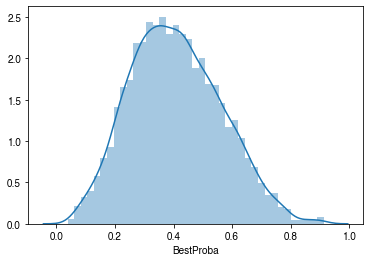

In [24]:
sns.distplot(cell_level_pred['BestProba'])

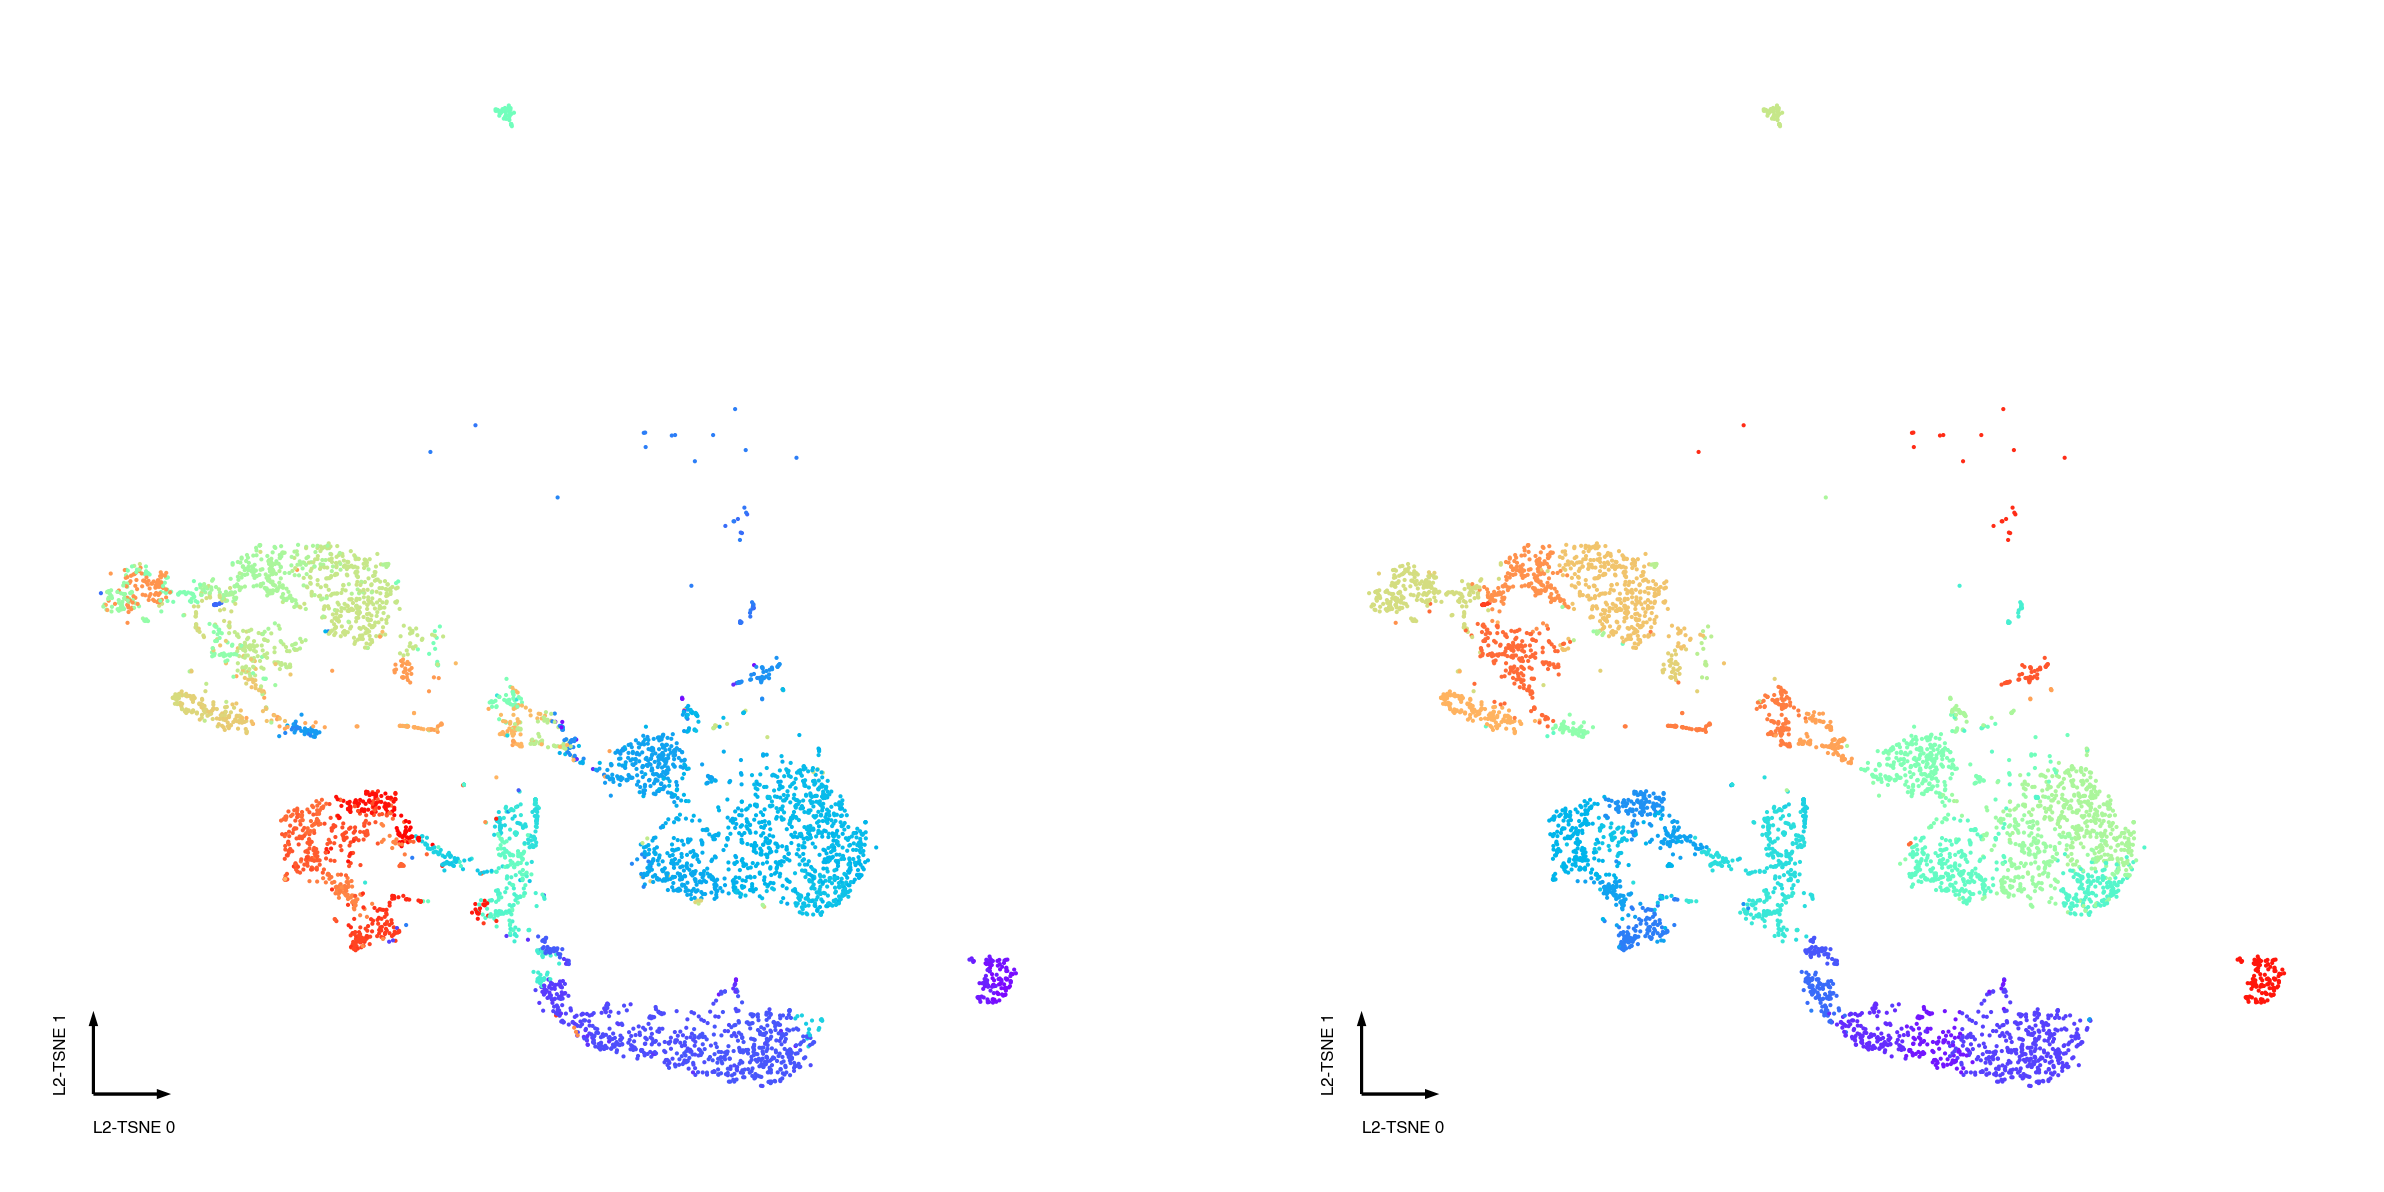

In [25]:
mc_pred_and_true = pd.DataFrame([mc_pred, mc_label], columns=mc_label.index).T
mc_pred_and_true.columns = ['Pred', 'True']

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), dpi=300, ncols=2)

categorical_scatter(data=mc_tidy_data, ax=ax1, coord_base='l2-tsne', 
                    hue=mc_pred_and_true['Pred'], s=1)

categorical_scatter(data=mc_tidy_data, ax=ax2, coord_base='l2-tsne', 
                    hue=mc_pred_and_true['True'], s=1)

pass

#### Cluster Level

In [26]:
pred_true_count = mc_pred_and_true.groupby('True')['Pred'].value_counts().unstack().fillna(0).astype(int)
pred_true_ratio = pred_true_count / pred_true_count.sum(axis=1).values[:, None]

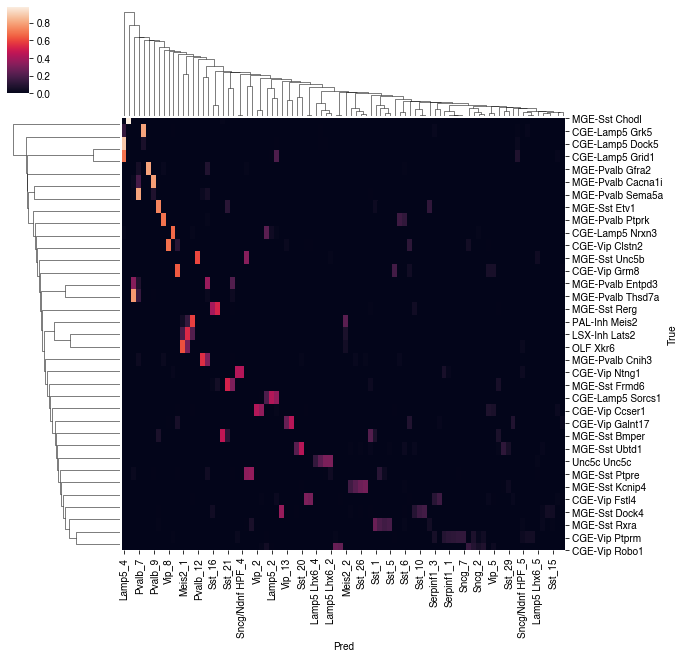

In [27]:
sns.clustermap(pred_true_ratio)

In [28]:
cluster_level_pred = pd.DataFrame(index=mc_tidy_data[cluster_col].unique())
cluster_level_pred['BestProba'] = pred_true_ratio.apply(lambda i: i.max(), axis=1)
cluster_level_pred['BestMatch'] = pred_true_ratio.apply(lambda i: i.idxmax(), axis=1)
cluster_level_pred.to_csv('Model/mC_cluster_to_RNA_cluster.csv')

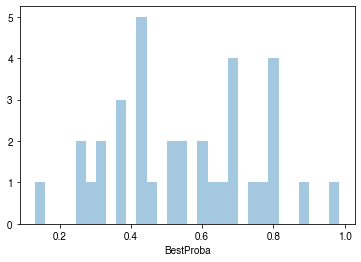

In [30]:
sns.distplot(cluster_level_pred['BestProba'], bins=30, kde=False)

In [31]:
print('mC cluster best match to RNA cluster:', cluster_level_pred['BestMatch'].value_counts().size)
print('Total mC cluster:', mc_tidy_data[cluster_col].unique().size)
print('Total RNA cluster:', rna_tidy_data[cluster_col].unique().size)

mC cluster best match to RNA cluster: 34
Total mC cluster: 35
Total RNA cluster: 90
